# Parte practica parcial modelos predictivos

### Modelos ARIMA para la TRM
### Modelos de volatilidad para el NASDAQ-100

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from datetime import datetime,timedelta

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
from arch import arch_model

## Modelos ARIMA para la TRM

In [4]:
trm=pd.read_csv("TRM.csv")

In [5]:
trm.VIGENCIADESDE=pd.to_datetime(trm.VIGENCIADESDE,format='%d/%m/%Y')
trm.set_index(pd.DatetimeIndex(trm.VIGENCIADESDE),inplace=True)

In [6]:
trm_mensual=trm.resample(rule="M").last()

#### Se escogen los modelos con base en la muestra de entrenamiento

In [7]:
training=trm_mensual.loc[:"2018-12","VALOR"]

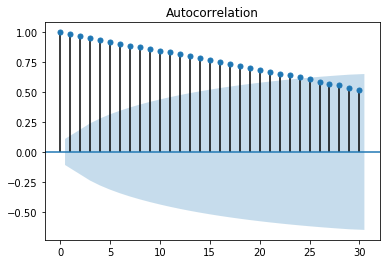

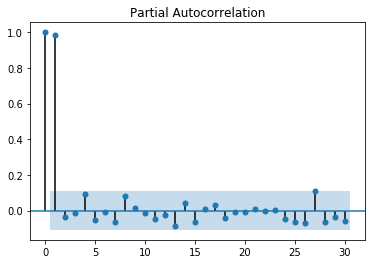

In [8]:
plot_acf(training,lags=30)
plot_pacf(training,lags=30)
plt.show()

In [9]:
adfuller(training)

(-1.2397141525273483,
 0.6562827382836951,
 14,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 3541.3822844524047)

#### Comprobamos que la serie diferenciada de la TRM es estacionaria

In [10]:
adfuller(training.diff(1).dropna())

(-4.022998284932709,
 0.0012947594353015608,
 13,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 3530.638091699834)

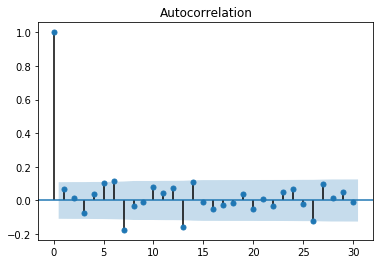

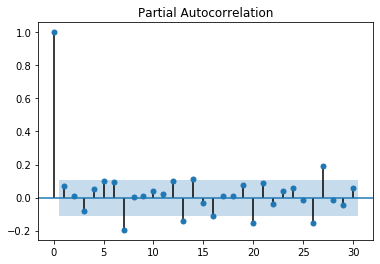

In [11]:
plot_acf(training.diff(1).dropna(),lags=30)
plot_pacf(training.diff(1).dropna(),lags=30)
plt.show()

### Escogemos 2 modelos ARIMA(1,1,1) y ARIMA(3,1,1)

In [12]:
observados=trm_mensual.loc["2019-01-31":"2019-09-30","VALOR"]

In [13]:
fecha_inicio,fecha_fin=pd.Timestamp('2010-12-31'),pd.Timestamp('2018-12-31')

#### Rolling window modelo ARIMA(1,1,1)

In [14]:
trm_forecast1=[]
for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)
    ventana=trm_mensual.loc[inicio:fin,"VALOR"]
    model=SARIMAX(ventana,order=(1,1,1))
    model_fit=model.fit()
    forecast=model_fit.get_forecast(steps=1).predicted_mean
    trm_forecast1.append(forecast[0])

#### Rolling window modelo ARIMA(3,1,1)

In [15]:
trm_forecast2=[]
for i in range(9):
    inicio,fin=fecha_inicio+pd.DateOffset(months=i),fecha_fin+pd.DateOffset(months=i)
    ventana=trm_mensual.loc[inicio:fin,"VALOR"]
    model=SARIMAX(ventana,order=(3,1,1))
    model_fit=model.fit()
    forecast=model_fit.get_forecast(steps=1).predicted_mean
    trm_forecast2.append(forecast[0])

In [16]:
MAE1=mean_absolute_error(observados,trm_forecast1)
MAE2=mean_absolute_error(observados,trm_forecast2)
print("El MAE para el primer modelo es %6.4f mientras que para el modelo 2 se tiene un MAE %6.4f"%(MAE1,MAE2))

El MAE para el primer modelo es 101.1363 mientras que para el modelo 2 se tiene un MAE 93.6879


#### Diferencia estadistica en los pronosticos

In [17]:
from dm_test import dm_test

In [18]:
rt = dm_test(observados,trm_forecast1,trm_forecast2,h = 1, crit="MSE")
print(rt)

dm_return(DM=1.3776602558805366, p_value=0.20561595208339856)


## Modelos de volatilidad

In [19]:
oxford=pd.read_csv("oxford.csv")

In [20]:
oxford.iloc[:,0]=oxford.iloc[:,0].str.split(" ",expand=True)[0]
oxford.rename(columns={'Unnamed: 0':'Dates'}, inplace=True)

In [21]:
oxford["Dates"]=pd.to_datetime(oxford["Dates"],format='%Y-%m-%d')
oxford.set_index(pd.DatetimeIndex(oxford["Dates"]),inplace=True)

In [22]:
nasdaq=oxford[oxford.Symbol==".IXIC"]

In [23]:
nasdaq_base=nasdaq.loc[:"2019-09-30",["close_price","rv5_ss"]]
nasdaq_base["retornos"]=np.log(nasdaq_base["close_price"]).diff(periods=1)*100
nasdaq_base=nasdaq_base.dropna()

### Modelo GARCH(1,1)

In [24]:
basic_gm = arch_model(nasdaq_base["retornos"], p = 1,q = 1, 
                      mean = 'zero', vol = 'GARCH',dist="t")

fecha_fin="2017-12-31"
gm_result = basic_gm.fit(last_obs="2017-12-31")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7326.584998469352
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7318.66657533158
Iteration:      3,   Func. Count:     21,   Neg. LLF: 7303.54804196632
Iteration:      4,   Func. Count:     27,   Neg. LLF: 7297.452004769738
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7293.717880656401
Iteration:      6,   Func. Count:     43,   Neg. LLF: 7291.850742320125
Iteration:      7,   Func. Count:     51,   Neg. LLF: 7288.605965152036
Iteration:      8,   Func. Count:     57,   Neg. LLF: 7286.852429934863
Iteration:      9,   Func. Count:     64,   Neg. LLF: 7286.201725291139
Iteration:     10,   Func. Count:     70,   Neg. LLF: 7286.146915769682
Iteration:     11,   Func. Count:     76,   Neg. LLF: 7286.140930734458
Iteration:     12,   Func. Count:     82,   Neg. LLF: 7286.140542604233
Iteration:     13,   Func. Count:     88,   Neg. LLF: 7286.140436471602
Iteration:     14,   Func. Count:     94,   Neg. LLF: 7286.1404320

In [25]:
print(gm_result.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                     retornos   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -7286.14
Distribution:      Standardized Student's t   AIC:                           14580.3
Method:                  Maximum Likelihood   BIC:                           14605.9
                                              No. Observations:                 4514
Date:                      Thu, Nov 19 2020   Df Residuals:                     4510
Time:                              21:56:42   Df Model:                            4
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

In [26]:
obs=np.sqrt(nasdaq_base.loc["2018-01-02":"2019-09-30","rv5_ss"])*np.sqrt(252)*100

### Rolling window

In [33]:
basic_gm=arch_model(nasdaq_base["retornos"],p=1,q=1,mean = 'zero', vol = 'GARCH',dist="t")
start_loc,end_loc=3006,4513
forecasts=dict()
for i in range(1,435):

    gm_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5)
    ;
    temp_result = np.sqrt(gm_result.forecast(horizon = 1).variance)
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
   
garch_forecast = pd.DataFrame(forecasts).T*np.sqrt(252)

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1864.2161748675944
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1862.7524313281585
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1862.752320737631
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1866.9699262291815
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1865.5848797489957
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1865.5846940487377
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1866.8934650422798
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1865.5169682207545
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1865.5167412490462
            Iterations: 12
    

Iteration:     10,   Func. Count:     69,   Neg. LLF: 1874.9427459040635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1874.9425331079651
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1879.4617067060744
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1878.1792338499909
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1878.1788941956586
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1879.7733126398418
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1878.4645370115304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1878.464175476869
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
Ite

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1888.407370866959
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1886.907610851915
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1886.9073104699005
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1888.6136603316172
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1887.122189968323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1887.1219305636566
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1888.6628824053855
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1887.191126831683
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1887.1908795517274
            Iterations: 13
       

Iteration:     15,   Func. Count:     98,   Neg. LLF: 1901.8345572220903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1901.8345572220846
            Iterations: 15
            Function evaluations: 98
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1901.5581672598464
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1899.3426052972864
Iteration:     15,   Func. Count:     98,   Neg. LLF: 1899.3200100455065
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1899.3200100455044
            Iterations: 15
            Function evaluations: 98
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1902.9904590399765
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1900.6133977638412
Iteration:     15,   Func. Count:     98,   Neg. LLF: 1900.5893458130572
Optimization terminated successfully.    (Exit mode 0)
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1890.3860766079488
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1890.8270374597778
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1889.4598910191826
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1889.4594712514534
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1890.674392388903
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1889.352166018994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1889.3518875698342
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1889.742759365784
Itera

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1874.580277372395
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1873.6973358388937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1873.6972530529051
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1875.4902548261146
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1874.6197707792148
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1874.6194640987649
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1875.5579156618542
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1874.7009688830096
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1874.7006386891355
            Iterations: 13
    

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1866.6617889369622
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1865.832849876018
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1865.8324725063403
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1867.4044546578777
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1866.6029394108705
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1866.6026928691294
            Iterations: 12
            Function evaluations: 80
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1869.3105849924063
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1868.5288538362393
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1868.5285909268305
            Iterations: 12
    

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1867.2774448532593
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1866.536222757335
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1866.5361251496852
            Iterations: 12
            Function evaluations: 80
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1868.3225285481744
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1867.6011760191695
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1867.6009597652412
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1868.5206323866505
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1867.799527216169
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1867.7994971248484
            Iterations: 12
     

Iteration:     10,   Func. Count:     68,   Neg. LLF: 1884.8125188496165
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1884.8100560205621
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1886.455342843025
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1885.450901905324
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1885.4487012790805
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     36,   Neg. LLF: 1886.6987572548842
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1885.6812949632865
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1885.6792091276232
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Iter

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1901.7610212028067
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1903.6048435517077
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1902.2857837719937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1902.2830453054867
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1906.0830373131328
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1904.7513434493078
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1904.7506918593008
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1906.764533287342
Ite

Iteration:      5,   Func. Count:     34,   Neg. LLF: 1919.8022258679935
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1918.364206737855
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1918.3640201395233
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1921.6780548913985
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1920.1792001212496
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1920.1791374083189
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1922.3831555710256
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1920.9860110110185
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1920.9858885651427
            Iterations: 12
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1929.425823668561
            Iterations: 13
            Function evaluations: 86
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1930.8531210851284
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1929.3188841917167
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1929.3178366051434
            Iterations: 12
            Function evaluations: 80
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1930.0053132680837
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1928.4250733756317
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1928.4249448810253
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1927.572510615877
Iter

Iteration:     10,   Func. Count:     68,   Neg. LLF: 1936.1864569180952
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1936.147964959413
            Iterations: 14
            Function evaluations: 92
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1938.6181984231634
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1936.820941642401
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1936.7822337278617
            Iterations: 14
            Function evaluations: 92
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1938.381284843479
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1936.6114902797785
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1936.5580139949464
            Iterations: 14
            Function evaluations: 92
            Gradient evaluations: 14
Itera

Iteration:      5,   Func. Count:     34,   Neg. LLF: 1925.8645574760778
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1924.0466219041334
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1923.9232495508782
            Iterations: 14
            Function evaluations: 93
            Gradient evaluations: 14
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1925.9903084785742
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1924.0324558035595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1924.0290268385895
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1926.2213912516665
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1924.2800348499986
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1924.276870184442
            Iterations: 13
    

Iteration:      5,   Func. Count:     34,   Neg. LLF: 1939.9885959445742
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1937.7971510107145
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1937.7953606390759
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1939.840206508386
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1937.712071070846
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1937.7096564221747
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1940.7862867209406
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1938.57306710547
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1938.5712093622678
            Iterations: 13
       

Iteration:      5,   Func. Count:     34,   Neg. LLF: 1934.6894901446112
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1932.3385533049675
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1932.3286863377411
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1935.5458880206295
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1933.2534381405983
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1933.2468722682866
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1935.3538751558733
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1933.0502990093048
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1933.042984029808
            Iterations: 13
    

            Current function value: 1954.6506874655233
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1956.5872335762965
Iteration:     10,   Func. Count:     70,   Neg. LLF: 1954.633737330903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1954.6336809704549
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1960.1494133038586
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1957.8620619477524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1957.8607223949857
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1960.2306227580198
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1957

Iteration:     10,   Func. Count:     70,   Neg. LLF: 1961.159536633817
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1961.1595345783226
            Iterations: 11
            Function evaluations: 76
            Gradient evaluations: 11
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1964.31136288768
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1962.3145856499777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1962.3137872072427
            Iterations: 14
            Function evaluations: 92
            Gradient evaluations: 14


### Modelo EWMA

In [28]:
from arch.univariate import EWMAVariance,ZeroMean
ret=ZeroMean(nasdaq_base["retornos"])
ret.volatility=EWMAVariance(lam=0.95)
ewma=ret.fit()
ewma_forecast=np.sqrt(ewma.forecast(horizon=1,start="2017-12-31").variance["2017-12-31":])*np.sqrt(252)

### Comparasión pronósticos

In [29]:
volatilidad=pd.concat([obs,garch_forecast,ewma_forecast],axis=1)
volatilidad.columns=["Realized Vol","Garch","EWMA"]

Función de perdida de Patton

$$QL=\dfrac{\sigma^{2}_{t}}{\hat{\sigma}^{2}_{t|t-1}}-ln\left(\dfrac{\sigma^{2}_{t}}{\hat{\sigma}^{2}_{t|t-1}}\right)-1$$

In [30]:
volatilidad["QL_garch"]=volatilidad["Realized Vol"]/volatilidad["Garch"]-np.log(volatilidad["Realized Vol"]/volatilidad["Garch"])-1
volatilidad["QL_EWMA"]=volatilidad["Realized Vol"]/volatilidad["EWMA"]-np.log(volatilidad["Realized Vol"]/volatilidad["EWMA"])-1

In [31]:
mse_garch=mean_squared_error(volatilidad["Realized Vol"],volatilidad["Garch"])
QL_garch=np.mean(volatilidad["QL_garch"])
mse_ewma=mean_squared_error(volatilidad["Realized Vol"],volatilidad["EWMA"])
QL_ewma=np.mean(volatilidad["QL_EWMA"])

In [32]:
print("El MSE del modelo GARCH(1,1) es %6.4f y el valor QL es %6.4f" %(mse_garch,QL_garch))
print("El MSE del modelo EWMA es %6.4f y el valor QL es %6.4f" %(mse_ewma,QL_ewma))

El MSE del modelo GARCH(1,1) es 46.2580 y el valor QL es 0.1044
El MSE del modelo EWMA es 64.4884 y el valor QL es 0.1330
